# Atari Pong Classic Reinforcement Learning

# Imports

In [33]:
import gymnasium as gym
from matplotlib import pyplot as plt
import numpy as np
from random import random, randrange, seed
from torch.nn.functional import conv2d
import torch
from tqdm import tqdm
import os

# Constants

In [34]:
seed(97120)
np.random.seed(97120)

episodes = 10
TEST_NAME = f"gaussian_5_{episodes}"

In [35]:
if not os.path.exists(f"./train_history/{TEST_NAME}/"):
  os.mkdir(f"./train_history/{TEST_NAME}")

# Utils

In [36]:
def normalize(data):
  data = data - data.mean()
  data = data / data.std()
  return data

In [37]:
def preprocessing(obs):
    # clipping and resizing the observation of the screen
    obs = obs[35:192:3, ::2, :]
    return obs

In [38]:
def get_actions_from_env(env):
    actions = env.action_space.n
    return list(range(0, actions))

In [39]:
def plot_qtable_backup(q_table, action=3, save=False):
  #q_table = normalize(q_table)
  
  fig, axs = plt.subplots(3, 6, figsize=(12, 5))
  fig.suptitle(f'Action {action} (position racket)')

  for idx, i in enumerate(range(0,54,3)):  
    axs[idx//6, idx%6].imshow(q_table[:,:,i,action], vmin=-1, vmax=1, cmap="gray")
    axs[idx//6, idx%6].set_title(f"{i}")
  
  if save:
    plt.savefig(f"./train_history/{TEST_NAME}/{TEST_NAME}_QT_A{action}")
    
  plt.show()

In [40]:
def plot_qtable(q_table, action=3, save=False):
  #q_table = normalize(q_table)
  
  fig, axs = plt.subplots(9, 6, figsize=(12, 12))
  fig.suptitle(f'Action {action} (position racket)')

  for idx, i in enumerate(range(0,54)):  
    axs[idx//6, idx%6].imshow(q_table[:,:,i,action], vmin=-1, vmax=1, cmap="gray")
    axs[idx//6, idx%6].set_title(f"{i}")
  
  if save:
    plt.savefig(f"./train_history/{TEST_NAME}/{TEST_NAME}_QT_A{action}")
    
  plt.show()

# Policies

In [41]:
def exploration_policy() -> int:
    return randrange(3) + 1

In [42]:
def greedy_policy(actions):
    actions = actions[:4]
    return np.where(actions == actions.max())[0][0].item()

In [43]:
def e_greedy_policy(actions, e=0.9):
    actions = actions[:4]
    # print(f"actions shape {actions.shape}")
    # print(f"actions {actions}")
    # print(f"where {np.where(actions == actions.max())}")
    return (
        np.random.randint(0, actions.shape[0], (1,))[0]
        if random() < (1 - e)
        else np.where(actions == actions.max())[0][0]
    )

# Qlearning

In [44]:
class QLearning:
    def __init__(self, qtable_file: str = None):
        self.setup(qtable_file)              

        self.state = 0
        self.action = 0
        self.reward = 0
        self.update_past(np.zeros((53 + 1, 80 + 1, 3)), 0, 0)

        # gaussian reward smoothing variables
        # 5x5 kernel
        self.kernel = np.array([1, 4, 7, 4, 1])
        self.kernel = np.matmul(self.kernel.reshape(5,1), self.kernel.reshape(1,5))
        self.kernel = self.kernel / 49

        assert self.kernel.shape[0] == self.kernel.shape[1] # square matrix
        assert self.kernel.shape[0]%2 != 0                  # kernel with odd dimensions
        

    def setup(self, qtable_file: str = None):
        self.qtable = 0

        if qtable_file is None:
            #self.qtable = np.random.rand(53, 80, 53 + 1, 6).astype(np.float32)
            self.qtable = np.zeros((53, 80, 53 + 1, 6)).astype(np.float32)
        else:
            self.qtable = np.array(np.load(qtable_file))

        self.qtable = self.qtable[0] if type(self.qtable) is tuple else  self.qtable
       

    def step(self, state_next, reward, alpha=0.3, gamma=0.9):
        # states to coordinates
        ball, green = self.get_entities_positions(self.state)
        ball_next, green_next = self.get_entities_positions(state_next)
        action_next = greedy_policy(self.get_actions_by_obs(state_next))

        # gaussian qlearning
        ball_x, ball_y = self.ball_pos_to_coordinates(ball)
        ball_x_next, ball_y_next = self.ball_pos_to_coordinates(ball_next)

        min_x, max_x, min_y, max_y, kernel = self.get_ball_range(ball)
        min_green = green - 1 if green - 1 >= 0 else 0
        max_green = green + 2 if green + 2 < 53 else 53

        if abs(self.reward) > 0.5 and False:
            print(f"kernel {kernel}")
            print(f"alpha: {alpha}, gamma: {gamma}, green: {green}")
            print(f"qtable next: {self.qtable[ball_x_next, ball_y_next, green_next, action_next]}")
            print(f"qtable: {self.qtable[ball_x, ball_y, green, self.action]}")
            print(f"reward: {self.reward}")
            p_sum = gamma * self.qtable[ball_x_next, ball_y_next, green_next, action_next] - self.qtable[ball_x, ball_y, green, self.action]
            p_sum_2 = (self.reward + p_sum)*alpha*kernel
            print(f"psum: {p_sum}")
            print(f"psum2: {p_sum_2.shape}") 

            value = alpha * (
            self.reward
            + gamma
            * self.qtable[ball_x_next, ball_y_next, green_next, action_next]
            - self.qtable[ball_x, ball_y, green, self.action]
            )
            print(f"value {value}")
            print(f"qtdest {self.qtable[min_x:max_x, min_y:max_y, green, self.action]}")

        self.qtable[min_x:max_x, min_y:max_y, green, self.action] += kernel * alpha * (
            self.reward
            + gamma
            * self.qtable[ball_x_next, ball_y_next, green_next, action_next]
            - self.qtable[ball_x, ball_y, green, self.action]
        )

        self.update_past(state_next, action_next, reward)

    def update_past(self, state, action, reward):
        self.state = state
        self.action = action
        self.reward = reward

    def get_entities_positions(self, obs):
        """
        Given an observation the function returns the pixel coordinates
        of the rackets and the ball.

        NB:The coordinate of each entity (ball, racket_0, racket_1) are choosen
        as the last pixel from left to right and the last from top to bottom.
        """
        # segmenting the agents and the ball
        ball_obs = np.expand_dims((obs[:, :, 2] > 200) * 1, 2)

        green_player_obs = np.expand_dims((obs[:, :, 1] > 180) * 1, 2)
        green_player_obs = green_player_obs - ball_obs

        # retrieving agents and ball position
        ball_obs = ball_obs.reshape(-1)
        ball_pos = np.max(ball_obs * np.arange(ball_obs.shape[0]))

        green_player_obs = green_player_obs.reshape(-1)
        green_pos = np.max(green_player_obs * np.arange(green_player_obs.shape[0]))

        return (
            int(ball_pos.item()),
            int(self.racket_pos_to_coordinates(green_pos).item()),
        )

    def racket_pos_to_coordinates(self, pos):
        return np.floor(pos / 80) + (1 if pos % 80 != 0 else 0)
    
    def ball_pos_to_coordinates(self, pos):
        x = int(np.floor(pos / 80) + (1 if pos % 80 != 0 else 0))
        x = 52 if x >= 53 else x

        y = int(pos%80)
        y = 79 if y >= 80 else y
        return x, y

    def get_ball_range(self, ball_pos):
        """Verify that the gaussian slice selection of the qtable uses correct indexes
        """
        kernel_size = self.kernel.shape[0]
        ball_x, ball_y = self.ball_pos_to_coordinates(ball_pos)
        delta = (self.kernel.shape[0]-1)/2

        min_x = ball_x - delta if ball_x - delta >= 0 else 0 
        max_x = ball_x + delta +1 if ball_x < 54 else 53

        min_y = ball_y - delta if ball_y - delta >= 0 else 0 
        max_y = ball_y + delta +1 if ball_y < 81 else 80
        
        kmin_x = 0 if min_x > 0 else -kernel_size + abs(ball_x - delta)
        kmax_x = 5 if max_x < 53 else kernel_size - abs(53-(ball_x + delta + 1))
        kmin_y = 0 if min_y > 0 else -kernel_size + abs(ball_y - delta)
        kmax_y = 5 if max_y < 80 else kernel_size - abs(80-(ball_y + delta + 1))

        kernel = self.kernel[int(kmin_x):int(kmax_x), int(kmin_y):int(kmax_y)]
        #kernel = np.expand_dims(kernel, -1)
        return int(min_x), int(max_x), int(min_y), int(max_y), kernel

    def get_actions_by_obs(self, state):
        ball, green = self.get_entities_positions(state)
        ball_x, ball_y = self.ball_pos_to_coordinates(ball)
        actions = self.qtable[ball_x, ball_y, green, :]

        return actions

    def save_qtables(self, name):
        np.save(f"./train_history/{TEST_NAME}/{TEST_NAME}", self.qtable)

    def clip_qtable(self):
        self.qtable = np.clip(self.qtable, -2, 2)

# Training

In [45]:
q_learn = QLearning("./train_history/gaussian_5_18000/gaussian_5_18000.npy")
env = gym.make("ALE/Pong-v5")#, render_mode="human")
history = []

In [46]:

for episode in range(episodes):
    print(f"Episode {episode}")
    cumulative_reward = 0

    obs, info = env.reset(seed=97120)
    obs = preprocessing(obs)

    for c in range(1000):
        #print(f"cycle {c}")
        #action = env.action_space.sample()
        action = e_greedy_policy(q_learn.get_actions_by_obs(obs), 0.9)

        obs, reward, term, trunc, info = env.step(action)
        obs = preprocessing(obs)  # cleaning useless pixels from obs

        #reward -= 0.001

        # qlearning
        q_learn.step(obs, reward)

        # game leaderboard
        cumulative_reward += reward

        if abs(reward) > 0.5 and False:
            _, green = q_learn.get_entities_positions(q_learn.state)
            print(f"action {action}, reward {reward} ({cumulative_reward}) - green: {green} - min:{q_learn.qtable.min()}, max: {q_learn.qtable.max()}")
            plot_qtable(np.clip(q_learn.qtable, -10, 10), action)

    #q_learn.clip_qtable()
    history.append(cumulative_reward)
    print(f"{'CONCLUSO' if term else 'TRONCATO'} => {cumulative_reward}")

env.close()
q_learn.save_qtables(f"./train_history/{TEST_NAME}/{TEST_NAME}")

Episode 0
TRONCATO => -7.0
Episode 1
TRONCATO => -1.0
Episode 2
TRONCATO => 0.0
Episode 3
TRONCATO => -3.0
Episode 4
TRONCATO => -6.0
Episode 5
TRONCATO => -3.0
Episode 6
TRONCATO => -4.0
Episode 7
TRONCATO => -1.0
Episode 8
TRONCATO => 0.0
Episode 9
TRONCATO => -4.0
Episode 10
TRONCATO => -5.0
Episode 11
TRONCATO => -5.0
Episode 12
TRONCATO => -1.0
Episode 13
TRONCATO => -4.0
Episode 14
TRONCATO => -4.0
Episode 15
TRONCATO => -9.0
Episode 16
TRONCATO => -3.0
Episode 17
TRONCATO => -2.0
Episode 18
TRONCATO => -4.0
Episode 19
TRONCATO => -1.0
Episode 20
TRONCATO => -2.0
Episode 21
TRONCATO => 0.0
Episode 22
TRONCATO => -4.0
Episode 23
TRONCATO => -2.0
Episode 24
TRONCATO => -6.0
Episode 25
TRONCATO => -5.0
Episode 26
TRONCATO => -4.0
Episode 27
TRONCATO => -7.0
Episode 28
TRONCATO => -4.0
Episode 29
TRONCATO => 0.0
Episode 30
TRONCATO => 0.0
Episode 31
TRONCATO => -4.0
Episode 32
TRONCATO => -7.0
Episode 33
TRONCATO => -8.0
Episode 34
TRONCATO => -4.0
Episode 35
TRONCATO => 1.0
Episode 

# Plotting

## Cumulative reward

In [47]:
history = np.array(history)

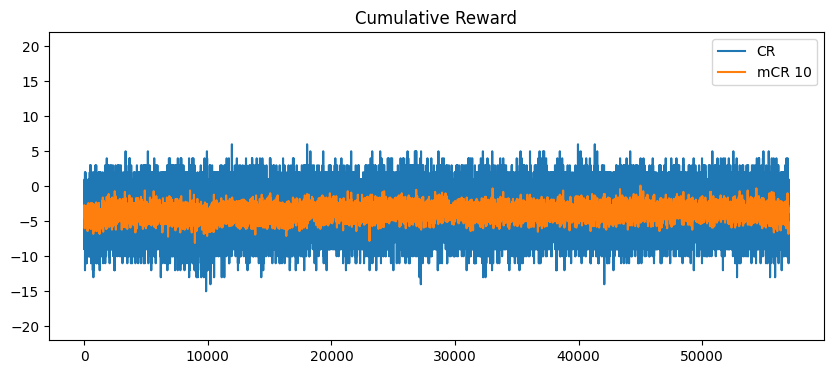

In [48]:
mean_window = 10
mean_cr = np.zeros(history.shape[0] - mean_window)
for idx in range(history.shape[0] - mean_window):
    mean_cr[idx] = history[idx:idx + mean_window].mean()

np.save(f"./train_history/{TEST_NAME}/{TEST_NAME}_history", history)
    
plt.figure(figsize=(10, 4))
plt.title("Cumulative Reward")
plt.plot(history, label="CR")
plt.plot(mean_cr, label="mCR 10")
plt.legend(loc="upper right")
plt.ylim([-22, 22])
plt.savefig(f"./train_history/{TEST_NAME}/{TEST_NAME}_CR")
plt.show()

## Qtable 

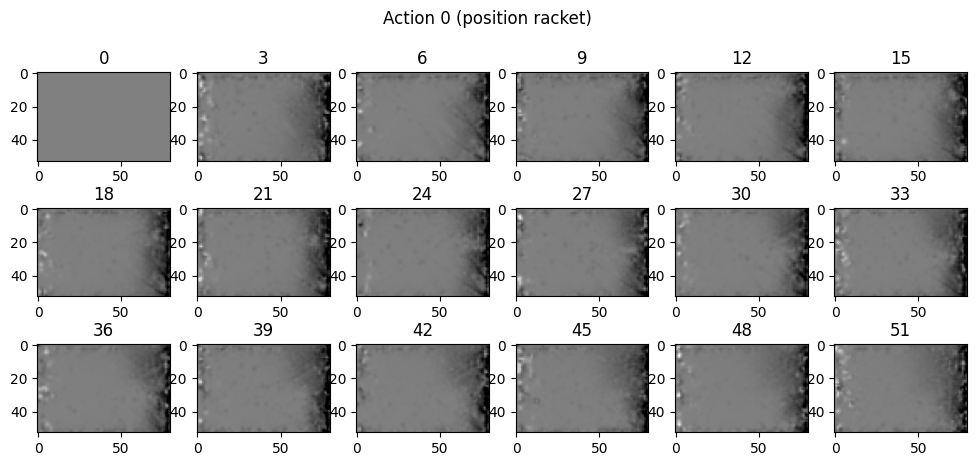

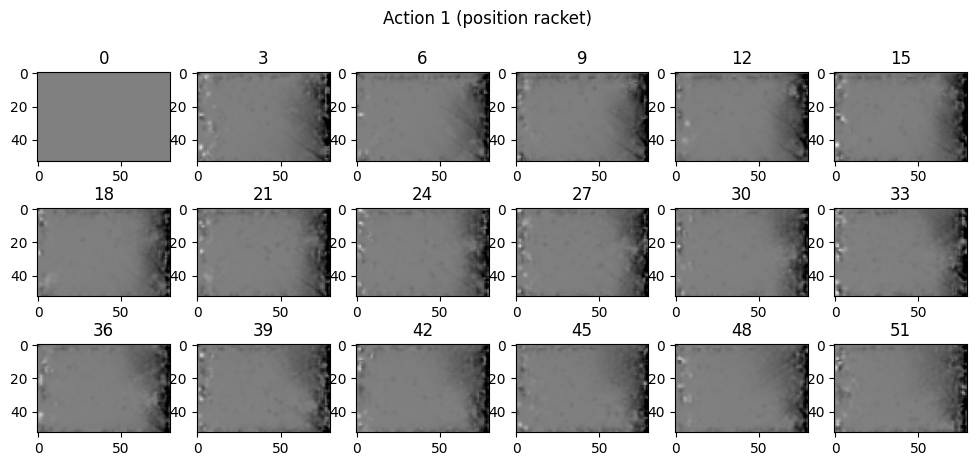

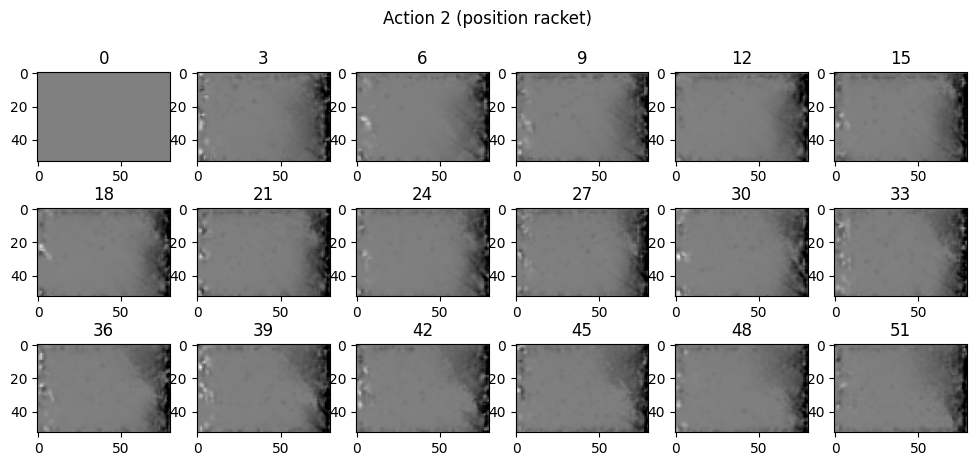

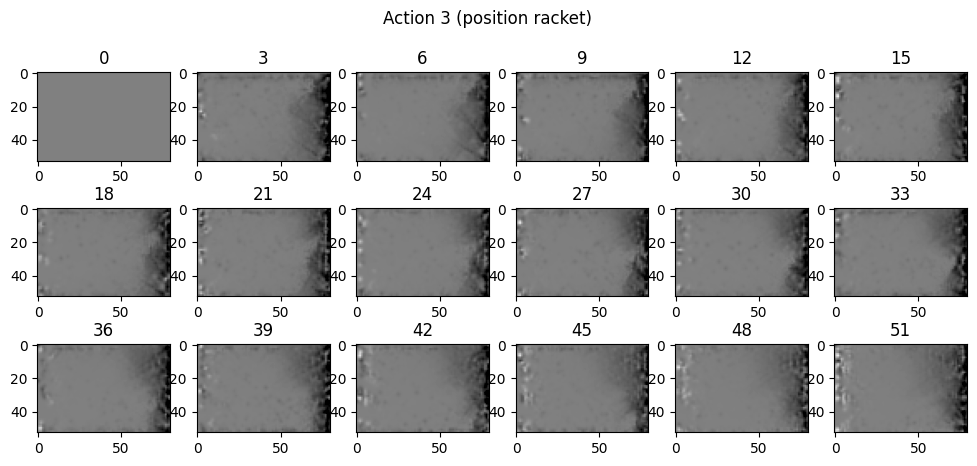

In [49]:
for action in range(4):
  plot_qtable_backup(q_learn.qtable, action, save=True)

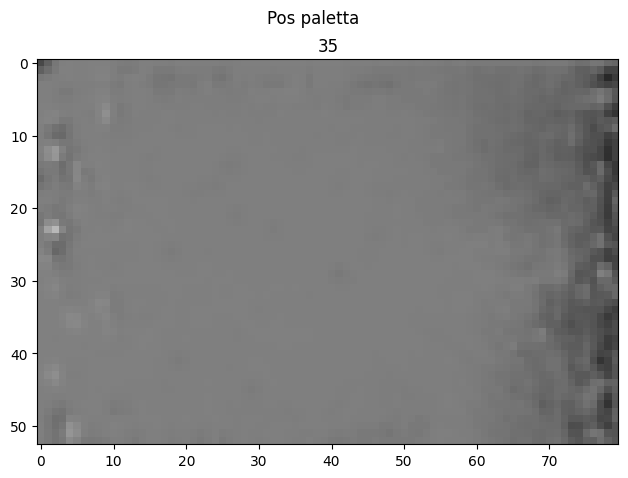

In [50]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
fig.suptitle('Pos paletta')

axs.imshow(q_learn.qtable[:,:,30,1], vmin=-2, vmax=2, cmap="gray")
axs.set_title(f"35")

plt.show()